In [7]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3 as sql
%matplotlib inline
from plotly import graph_objs as go
import re
import string
import warnings
warnings.filterwarnings('ignore')


## Data Preparation

In [8]:
df = pd.read_csv('train_preprocess.tsv.txt', sep='\t', names = ['Tweet','Label'])
df.head()

,Tweet,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [9]:
df.shape

(11000, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   11000 non-null  object
 1   Label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [11]:
df.isna().sum()

Tweet    0
Label    0
dtype: int64

In [12]:
df.duplicated().sum()

67

In [13]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

## EDA

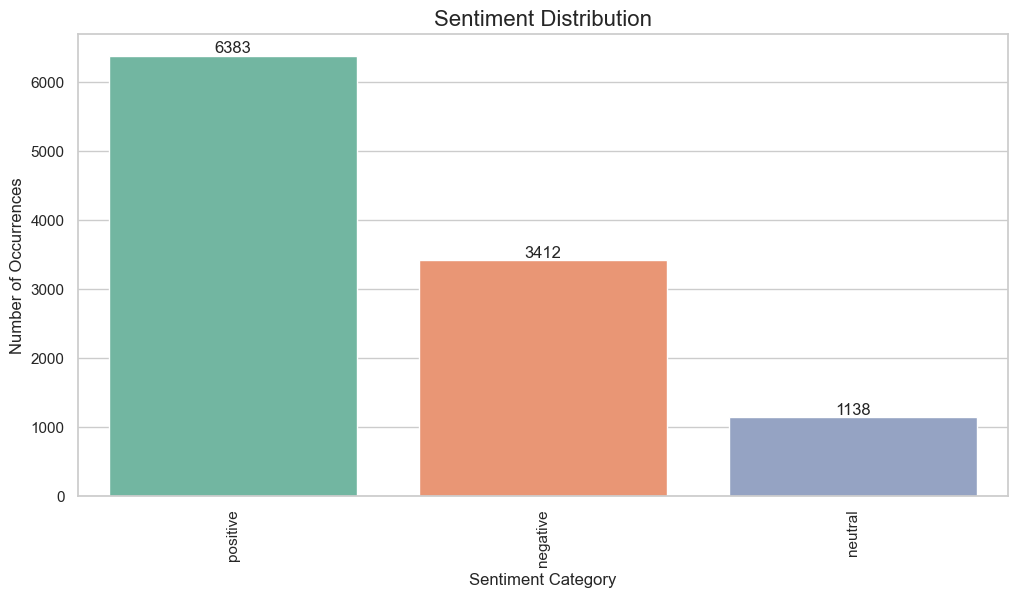

In [14]:
sentimen_distribution = df.Label.value_counts()

# Tentukan palet warna yang lebih menarik
custom_palette = sns.color_palette("Set2")

# Buat plot
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")  # Mengatur tema
barplot = sns.barplot(x=sentimen_distribution.index, y=sentimen_distribution.values, palette=custom_palette)

# Tambahkan label pada batang grafik
for index, value in enumerate(sentimen_distribution):
    barplot.text(index, value, value, ha='center', va='bottom')

plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment Category', fontsize=12)
plt.xticks(rotation=90)

plt.title('Sentiment Distribution', fontsize=16)  # Tambahkan judul grafik

plt.show()

In [15]:
fig = go.Figure(go.Funnelarea(
    text =sentimen_distribution.index,
    values = sentimen_distribution.values,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [16]:
df['Total_Words'] = df.Tweet.apply(lambda x: len(x.split()))

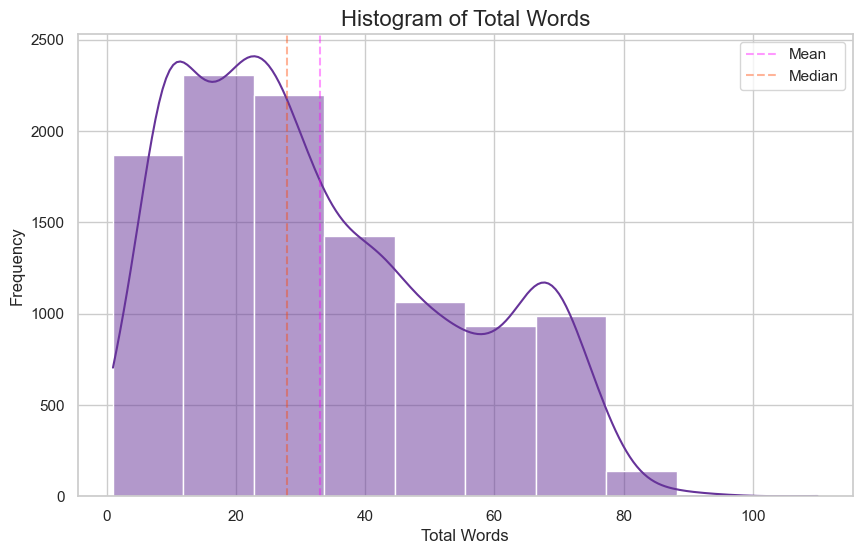

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Total_Words'], kde=True, color='RebeccaPurple', bins=10)
plt.axvline(x=df['Total_Words'].mean(),ls='--',color='Magenta',alpha=0.4,label='Mean')
plt.axvline(x=df['Total_Words'].median(),ls='--',color='OrangeRed',alpha=0.4,label='Median')

# Menambahkan label
plt.xlabel('Total Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Total Words', fontsize=16)

plt.legend()
plt.show()

In [18]:
df = df.drop('Total_Words', axis=1)

## Text Preprocessing

In [19]:
#Mengambil dan melihat dataset
connection_data = sql.connect('database.db', check_same_thread= False)
cursor = connection_data.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables =cursor.fetchall()
print('Daftar Table')
for i in tables:
  print(i[0])

Daftar Table
kamusalay
data
new_data
stopword


In [20]:
# Mengambil Kembali Stopword
q_stopword = 'SELECT * FROM stopword'
t_stopword = pd.read_sql_query(q_stopword, connection_data)
t_stopword

,STOPWORD
0,ada
1,adalah
2,adanya
3,adapun
4,agak
...,...
769,nih
770,wkwk
771,haha
772,eh


In [21]:
kamusalay_query = 'SELECT * FROM kamusalay'
df_kamusalay = pd.read_sql_query(kamusalay_query, connection_data)
dict_alay = dict(zip(df_kamusalay['alay'], df_kamusalay['normal']))

In [22]:
def preprocess_text(text):
    # Mengubah teks menjadi huruf kecil
    text = text.lower()
    # Menghapus URL dan tautan
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', ' ', text)
    text = re.sub(r'pic.twitter.com.[\w]+', ' ', text)
    # Menghapus karakter yang tidak diinginkan, termasuk angka
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Menghapus kata 'user'
    text = text.replace('user', '')
    # Menghapus spasi berlebih
    text = re.sub(' +', ' ', text)
    # Menghapus karakter \n (newline)
    text = text.replace('\n', ' ')
    # menghapus kata 'url' 
    text = re.sub('url',' ', text)
    return text

def normalize_text(text):
    data_alay = pd.read_sql_query('select * from kamusalay', connection_data)
    dict_alay = dict(zip(data_alay['alay'], data_alay['normal'])) #Membungkus data teks_alay dan teks baku menjadi dictionary
    text_list = text.split()
    
    text_normal_list = [dict_alay.get(word, word) for word in text_list] #Mengambil nilai baku pada data teks_baku
    
    text_normal = ' '.join(text_normal_list) #mengganti teks yang tidak baku menjadi baku
    return text_normal.strip()

# Fungsi Stopword Removal
def stopword_removal(text):
    stopword_words = set(t_stopword['STOPWORD'])
    words = text.split()
    filtered_words = [word for word in words if word not in stopword_words]
    return ' '.join(filtered_words)

def cleansing(text):
    text = preprocess_text(text)
    text = normalize_text(text)
    text = stopword_removal(text)
    return text

In [23]:
new_data = df.copy()
new_data.head()

,Tweet,Label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [24]:
new_data['Tweet']= new_data['Tweet'].apply(cleansing)
new_data.head(20)

,Tweet,Label
0,warung dimiliki pengusaha pabrik puluhan terke...,positive
1,mohon ulama lurus k mmbri hujjah partai diwlh ...,neutral
2,lokasi strategis jalan sumatra bandung nyaman ...,positive
3,betapa bahagia unboxing paket barang bagus men...,positive
4,aduh mahasiswa sombong kasih kartu kuning bela...,negative
5,makanan beragam harga makanan food stall kasir...,positive
6,pakai kartu kredit baca untung rugi,negative
7,unik bagus foto makanan enak pegawai ramah ber...,positive
8,keluarga menikmati pengalaman kuliner menyenan...,positive
9,bersyukur,positive


In [25]:
print('Old tweet: {}'.format(df['Tweet'].iloc[19]))
print('\t')
print('New tweet: {}'.format(new_data['Tweet'].iloc[19]))

Old tweet: sgwr 2018 beri dampak positif terhadap hobi anak-anak
	
New tweet: sgwr dampak positif hobi anak anak


In [26]:
new_data.to_sql('new_data', connection_data, if_exists='replace', index=False)
new_data = pd.DataFrame(new_data)
new_data

,Tweet,Label
0,warung dimiliki pengusaha pabrik puluhan terke...,positive
1,mohon ulama lurus k mmbri hujjah partai diwlh ...,neutral
2,lokasi strategis jalan sumatra bandung nyaman ...,positive
3,betapa bahagia unboxing paket barang bagus men...,positive
4,aduh mahasiswa sombong kasih kartu kuning bela...,negative
...,...,...
10993,f demokrat dorong upaya kemandirian energi nas...,neutral
10994,bosan,positive
10996,enak masakan kepiting menyenangkan memilih kep...,positive
10998,pagi pagi tol pasteur macet parah bikin jengkel,negative


In [27]:
connection_data.commit()
connection_data.close()